EPO

Complexity: O(m^2 n K)

Here, $m$ is the number of objectives, $K$ is the number of samples, and $n$ is the number of decision variables. For neural network based methods, $n$ is the number of parameters; hence $n$ is very large (>10000), K is also large (e.g., 20-50), while $m$ is small (2.g., 2-4).

As a result, m^2 is not a big problem. n^2 is a big problem. K^2 is a big problem.

PARETO FRONTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref
from libmoon.problem.synthetic.mop import BaseMOP
from paretoset import paretoset
import torch
torch.set_default_dtype(torch.float32)

In [15]:
# Import grid search data
gridsearchdata = np.load('Nam_ARneg_SensitivityPareto.npy')

from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

In [4]:
# CORE MATH FUNCTIONS

def abs_smooth(z, eps = 1e-8):
    return torch.sqrt(z * z + eps)

class XssNewton(torch.autograd.Function):
    @staticmethod
    def forward(ctx, alpha, n, it=30, tol=1e-10):
        x = torch.ones_like(alpha) #### Start near 1.0; any positive value works because the root is unique.
        for _ in range(int(it)): #### Iterate to refine x until it satisfies alpha / (1 + x^n) = x
            g   = alpha / (1.0 + x.pow(n)) - x  #### Compute ODE value: g = alpha / (1 + x^n) - x
            g_x = -1.0 - alpha * n * x.pow(n - 1.0) / (1.0 + x.pow(n)).pow(2.0)  # Compute derivative of g with respect to x
            step = g / g_x #### Newton step: Δx = g(x)/g'(x)
            x = x - step #### Update x
            #### check for convergence
            if torch.max(torch.abs(step)) < tol: # Stop when the L-infinity norm of the step or step size is tiny
                break
        # Save tensors for backward pass thus gradient computation
        ctx.save_for_backward(x, alpha, n)
        return x

    @staticmethod
    def backward(ctx, grad_out):
        x, alpha, n = ctx.saved_tensors
        g_x = -1.0 - alpha * n * x.pow(n - 1.0) / (1.0 + x.pow(n)).pow(2.0) #### g_x = ∂g/∂x. Again, g is the ODE
        g_a = 1.0 / (1.0 + x.pow(n)) #### g_alpha = ∂g/∂alpha
        #### d/dn [alpha/(1 + x^n)] = -alpha * (x^n * ln x) / (1 + x^n)^2
        g_n = -alpha * x.pow(n) * torch.log(x.clamp_min(1e-12)) / (1.0 + x.pow(n)).pow(2.0) #### g_n = ∂g/∂n   (note the log(x); clamp to avoid log(0))
        #### Chain rule: gradient of output with respect to inputs
        coeff = -grad_out / g_x
        d_alpha = coeff * g_a
        d_n     = coeff * g_n
        return d_alpha, d_n, None, None #### The last two Nones correspond to it and tol, which are not tensors

In [5]:
# DEFINE PROBLEM

# Define the multi-objective optimization problem
class SensitivityMOP(BaseMOP):

    # Initialize the problem
    def __init__(self, eps = 1e-8):
        super().__init__(n_var=2, n_obj=2, n_cons=0)
        self.problem_name = "ZDT1" 
        self.n_dim = self.n_var = 2  #### Two variables: α and n
        self.n_obj = 2   #### Two objectives: S_α and S_n
        self.lbound = torch.tensor([0.001, 0.001])  #### Lower bounds for [α, n]
        self.ubound = torch.tensor([50.0 , 10.0 ])  #### Upper bounds for [α, n]
        self.eps = float(eps)   #### Numerical stability parameter

    # Evaluate the objectives for a batch of candidates
    def _evaluate_torch(self, z):

        # Set lower and upper bounds
        lb = self.lbound.to(z.device)
        ub = self.ubound.to(z.device)

        # Enforce box constraints 
        alpha = z[:, 0].clamp(lb[0], ub[0])
        n     = z[:, 1].clamp(lb[1], ub[1])

        # Find steady state using Newton's method
        x = XssNewton.apply(alpha, n) 

        # Calculate first sensitivity objective: S_α
        numerator1 = alpha * (1 + x.pow(n))
        denominator1 = x + alpha * n * x.pow(n) + 2 * x.pow(1+n) + x.pow(1+2*n)
        f1 = abs_smooth(numerator1 / denominator1, self.eps)
        
        # Calculate second sensitivity objective: S_n
        numerator2 = alpha * n * torch.log(x.clamp_min(1e-12)) * x.pow(n-1)
        denominator2 = 1 + alpha * n * x.pow(n-1) + 2 * x.pow(n) + x.pow(2*n)
        f2 = abs_smooth(-numerator2 / denominator2, self.eps)
        
        # Stack the two objectives into a single tensor 
        return torch.stack([f1, f2], dim=1) 

Derrick's code for one set of hyperparameters

In [6]:
# Instantiate the problem
problem = SensitivityMOP(eps=1e-8)

# Number of preference vectors (solutions to find); larger K means more coverage of the Pareto front
K = 100

# Generate uniform preference vectors (weights for objectives); Each row sums to 1. 
# These encourage coverage of different trade-off directions
prefs = get_uniform_pref(K, 2, clip_eps=1e-2) 

# Random initialization across the box (alpha, n)
lb, ub = problem.lbound, problem.ubound
x0 = lb + torch.rand(K, 2) * (ub - lb)

# Gradient-based Pareto optimizer
solver = EPOSolver(
    step_size=1e-1,   #### learning rate for gradient descent or Size of each optimization step (bigger = faster but riskier)
    n_epoch=100,      #### optimization iterations or number of epochs
    tol=1e-6,         #### early-stop threshold inside EPOSolver. Think of it as the tolerance for convergence
    problem=problem,  #### Optimization problem
    prefs=prefs  #### Preference weights
)

# Run optimization
res = solver.solve(x_init=x0)

100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


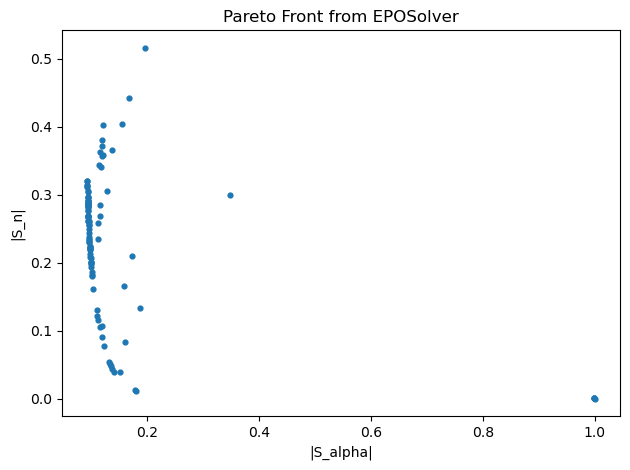

In [7]:
# Extract results
X = res["x"]  # Optimized alpha, n pairs
Y = res["y"]  # Sensitivities (S_alpha, S_n)

# Plot Pareto front
plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], s=12)
plt.xlabel("|S_alpha|")
plt.ylabel("|S_n|")
plt.title("Pareto Front from EPOSolver")
plt.tight_layout()
plt.show()

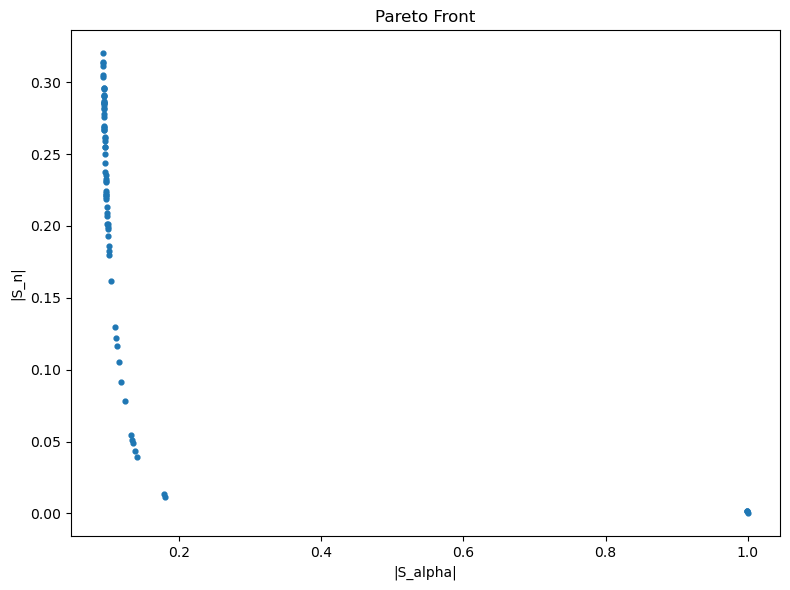

In [8]:
# Identify Pareto front using paretoset library
mask = paretoset(Y, sense=['min', 'min'])
Y_pf_paretoset = Y[mask]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(Y_pf_paretoset[:, 0], Y_pf_paretoset[:, 1], s=12)
plt.xlabel("|S_alpha|")
plt.ylabel("|S_n|")
plt.title("Pareto Front")
plt.tight_layout()
plt.show()

Loop hyperparameters

In [9]:
import time

In [10]:
# --- Parameter sweeps ---
Epochs_list = (np.linspace(1, 300, num=21)).astype(int)
Samps_list = (np.linspace(1, 500, num=21)).astype(int)

# Storage structure: rows = Samps, cols = Epochs
# ┌───────────────────────────────────────────────┐
# │                Number of Eqpochs (j)          │
# │            Epochs_1  Epochs_2  Epochs_3  ...  │
# ├───────────────────────────────────────────────┤
# │ Samps_1     [None]    [None]    [None]   ...  │
# │ Samps_2     [None]    [None]    [None]   ...  │
# │ Samps_3     [None]    [None]    [None]   ...  │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘
R, C     = len(Samps_list), len(Epochs_list)
all_F    = [[None for _ in range(C)] for _ in range(R)]  # objectives (fronts)
all_X    = [[None for _ in range(C)] for _ in range(R)]  # parameters
all_time = np.zeros((R, C), dtype=float)
all_size = np.zeros((R, C), dtype=int)

# --- Optimization loops ---
for i, Samps in enumerate(Samps_list):
    for j, Epochs in enumerate(Epochs_list):

        # Instantiate the problem
        problem = SensitivityMOP(eps=1e-8)

        # Number of preference vectors (solutions to find); larger K means more coverage of the Pareto front
        K = Samps

        # Generate uniform preference vectors (weights for objectives); Each row sums to 1. 
        prefs = get_uniform_pref(K, 2, clip_eps=1e-2) 

        # Random initialization across the box (alpha, n)
        lb, ub = problem.lbound, problem.ubound
        x0 = lb + torch.rand(K, 2) * (ub - lb)

        # Gradient-based Pareto optimizer
        solver = EPOSolver(
            step_size=1e-1,   #### learning rate for gradient descent or Size of each optimization step (bigger = faster but riskier)
            n_epoch=Epochs,      #### optimization iterations or number of epochs
            tol=1e-6,         #### early-stop threshold inside EPOSolver. Think of it as the tolerance for convergence
            problem=problem,  #### Optimization problem
            prefs=prefs)      #### Preference weights

        # --- precise CPU timing ---
        t0 = time.process_time()
        res = solver.solve(x_init=x0)
        exec_time_cpu = time.process_time() - t0
        # ---------------------------

        # Extract results
        X_raw = res["x"]  # Optimized alpha, n pairs
        Y_raw = res["y"]  # Sensitivities (S_alpha, S_n)

        # Identify Pareto front using paretoset library
        mask = paretoset(Y_raw, sense=['min', 'min'])
        X = X_raw[mask]
        Y = Y_raw[mask]

        # Store results in grid form
        all_F[i][j] = Y
        all_X[i][j] = X
        all_time[i, j] = exec_time_cpu
        all_size[i, j] = X.shape[0]


# Our final all_F and all_X structures
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │           Epochs_1  Epochs_2  Epochs_3  ...   │
# ├───────────────────────────────────────────────┤
# │ Samps_1  [F[0][0]] [F[0][1]] [F[0][2]]  ...   │
# │ Samps_2  [F[1][0]] [F[1][1]] [F[1][2]]  ...   │
# │ Samps_3  [F[2][0]] [F[2][1]] [F[2][2]]  ...   │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘

# Conver to numpy array
all_F_np = np.array(all_F, dtype=object)
all_X_np = np.array(all_X, dtype=object)

100%|██████████| 300/300 [07:00<00:00,  1.40s/it]


In [11]:
np.savez(
    "Nam_Data_LibmoonEpo_ArNeg.npz",
    all_F=all_F_np,
    all_X=all_X_np,
    all_time=all_time,
    all_size=all_size,
    Samps_list=Samps_list,
    Epochs_list=Epochs_list,
)

PERFORMANCE METRICS

In [8]:
# Load saved dataset
data = np.load("Nam_Data_LibmoonEpo_ArNeg.npz", allow_pickle=True)

# Check what's inside
print("Available keys:", data.files)

# Retrieve your stored arrays directly
all_F_np     = data["all_F"]
all_X_np     = data["all_X"]
all_time     = data["all_time"]
all_size     = data["all_size"]
Samps_list   = data["Samps_list"]
Epochs_list  = data["Epochs_list"]

# Dimensions
R, C = len(Samps_list), len(Epochs_list)
print("R:", R, "C:", C)

Available keys: ['all_F', 'all_X', 'all_time', 'all_size', 'Samps_list', 'Epochs_list']
R: 21 C: 21


Analysis: evolving Pareto fronts with population size (column wise evolution)

In [9]:
# Evolving Pareto fronts across Samps (rows) for each Epochs (column)
Storage_EvolvingParetos_Samps = np.empty((R, C), dtype=object)
Storage_EvolvingParams_Samps  = np.empty((R, C), dtype=object)

# Loop through Number of Epochs column-wise
for columnnum, Epochs in enumerate(Epochs_list):

    # Get the data for this Number of Epochs across all Sample Sizes
    Fcolumn = all_F_np[:, columnnum]
    Xcolumn = all_X_np[:, columnnum]

    # Column vectors to store sequence of Pareto front & parameter coordinates
    pareto_front_sequence = np.empty(R, dtype=object)
    pareto_param_sequence = np.empty(R, dtype=object)

    # Loop through populations
    for rownum, Samps in enumerate(Samps_list):
        
        # Initialize empty accumulators for this population size
        AllParetoFrontsUpToCurrentSamps = np.empty((0, 2))  # Initialize an empty array
        AllParetoParamsUpToCurrentSamps = np.empty((0, 2))  # Initialize an empty array

        # Accumulate data from the first run up to the current run
        for ind in range(rownum + 1):

            CurrentParetoFront = Fcolumn[ind].astype(float)
            AllParetoFrontsUpToCurrentSamps = np.vstack((AllParetoFrontsUpToCurrentSamps, CurrentParetoFront))

            CurrentParetoParam = Xcolumn[ind].astype(float)
            AllParetoParamsUpToCurrentSamps = np.vstack((AllParetoParamsUpToCurrentSamps, CurrentParetoParam))

        # Compute Pareto-optimal points
        mask = paretoset(AllParetoFrontsUpToCurrentSamps, sense=["min", "min"])
        filteredfront = AllParetoFrontsUpToCurrentSamps[mask]
        filteredparam = AllParetoParamsUpToCurrentSamps[mask]

        # Store Pareto front and pareto parameters for this row
        pareto_front_sequence[rownum] = filteredfront
        pareto_param_sequence[rownum] = filteredparam

    # Store the full column sequence for this generation
    Storage_EvolvingParetos_Samps[:,columnnum] = pareto_front_sequence
    Storage_EvolvingParams_Samps[:,columnnum]  = pareto_param_sequence

In [16]:
# Preallocate
IGDs = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)

# Define indicator once using the reference front
ind = IGD(gridsearchdata)

# Loop over epochs × sample sizes
for col, Epochs in enumerate(Epochs_list):
    for row, Samps in enumerate(Samps_list):
        pf = np.asarray(Storage_EvolvingParetos_Samps[row, col], dtype=float)
        IGDs[row, col] = ind(pf)

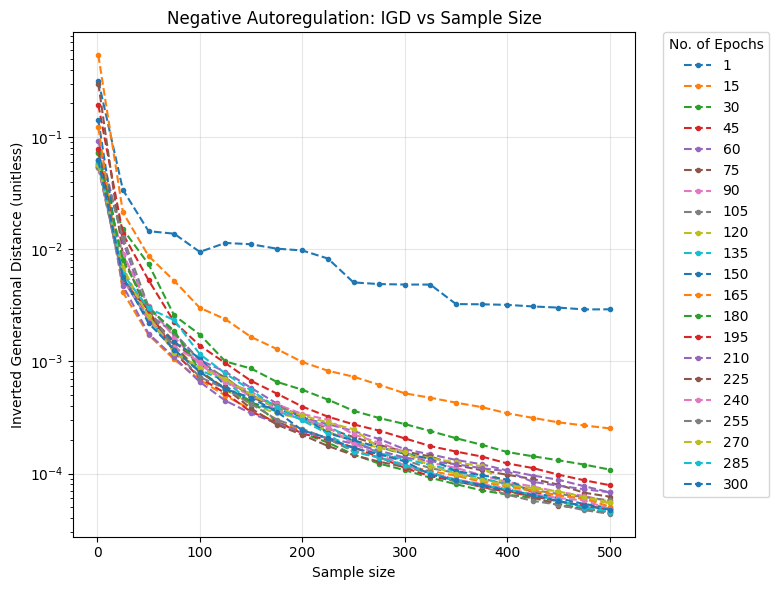

In [37]:
# --- Plot Inverse Generational Distance for each generation column ---
plt.figure(figsize=(10,6))

# Loop over each column (generation)
for col, Epochs in enumerate(Epochs_list):
    plt.plot(
        Samps_list, 
        IGDs[:, col], 
        marker='.', 
        linestyle='--', 
        label=f'{Epochs}'
    )

plt.xlabel("Sample size")
plt.ylabel("Inverted Generational Distance (unitless)")
plt.yscale("log")
plt.title("Negative Autoregulation: IGD vs Sample Size")

# --- Place legend outside on the right ---
plt.legend(
    title="No. of Epochs",
    bbox_to_anchor=(1.05, 1),  # x = 1.05 puts it just outside the plot
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leaves space for the legend
plt.show()

In [30]:
# --- Reference point based on true Pareto front (t) ---
buffer = 0.10  # 10% buffer beyond true front bounds
t_min = gridsearchdata.min(axis=0)
t_max = gridsearchdata.max(axis=0)
ref_point = t_max + buffer * (t_max - t_min)

hv = HV(ref_point=ref_point)
HV_true = float(hv(gridsearchdata))

# --- Initialize storage ---
HV_grid = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)
HV_ratio = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)

# --- Compute HV for each cell ---
for i in range(Storage_EvolvingParetos_Samps.shape[0]):      # population
    for j in range(Storage_EvolvingParetos_Samps.shape[1]):  # generations
        
        pf = Storage_EvolvingParetos_Samps[i, j]
        if pf is None or len(pf) == 0:
            continue
        
        pf = np.asarray(pf, dtype=float)
        hv_val = float(hv(pf))
        HV_grid[i, j] = hv_val
        HV_ratio[i, j] = hv_val / HV_true if HV_true > 0 else np.nan

print("Reference point:", ref_point)
print(f"True front HV: {HV_true:.6f}")
print("HV grid shape:", HV_grid.shape)
print("HV ratio grid shape:", HV_ratio.shape)

Reference point: [0.17400091 0.35207516]
True front HV: 0.022346
HV grid shape: (21, 21)
HV ratio grid shape: (21, 21)


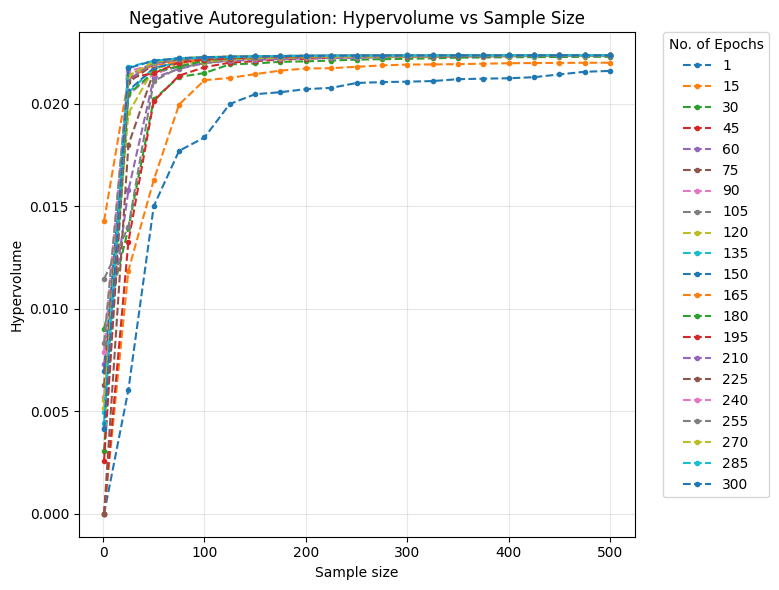

In [38]:
# --- Plot Hypervolume for each generation column ---
plt.figure(figsize=(10,6))

for col, Epochs in enumerate(Epochs_list):
    plt.plot(
        Samps_list,
        HV_grid[:, col],
        marker='.',
        linestyle='--',
        label=f'{Epochs}'
    )

plt.xlabel("Sample size")
plt.ylabel("Hypervolume")
plt.title("Negative Autoregulation: Hypervolume vs Sample Size")

# --- Legend outside the plot ---
plt.legend(
    title="No. of Epochs",
    bbox_to_anchor=(1.05, 1),  # x=1.05 puts legend just outside right edge
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave room for legend
plt.show()